In [1]:
print("start!")
HIDDEN_SIZE = 64
BATCH_SIZE = 64 # 64
LOG_ITERATIONS = 500
EPOCHS_NUM = 40

start!


## План
1. Разбить датасет на трейн/тест или на трейн/валидация/тест, как вам больше нравится
1. Сделать класс нейронки, вписать необходимые операции, базовая архитектура ниже
1. Написать обучалку
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__
    1. Каждую эпоху рассчитывать метрики __0.25 балла__
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__
1. Добавить early stopping __0.5 балла__
1. Отрисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__
1. Улучшить результат. Например, можно добавить BatchNorm, Dropout, Residual, etc __1 балл__
1. Сделать макро f1 больше 0.8 __1 балл__
1. Написать какие действия к чему приводили (почему вы их делали и оправдались ли ожидания)

## Базовая архитектура
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __1 балл__
1. Bidirectional LSTM. __1 балл__
2. Несколько параллельных CNN с разными размерами окна и пулингами к ним. __2 балла__
3. Конкатенация результатов CNN. __0 баллов__ (идет вместе с предыдущим пунктом)
4. Предикт в количество классов. __0 баллов__ (ну все-таки предсказать классы нужно обязательно)

__Дополнительные баллы:__
- Написать GRU с нуля самому __1 балл__
- Побить макро f1 0.84 __1 балл__
- Переобучиться и снизить переобучение за счет трюков. Пояснение: показываете, что вот такая архитектура переобучается, а вот я добавил/а это и это, изменил/а это и это и переобучение ушло __1 балл__
- Добавить селф аттеншин (написанный своими руками) __3 балла__
- За мультихед селф аттеншин еще __1 балл__
- Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
- Добавить дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
- Добавить шедуллеры __1 балл__
- your madness

### TIPs:
- Если будете брать ```train_test_split```, не забудьте сделать ```reset_index```, чтобы по индексу корректно доставались таргеты из ```y_data```  
- Необязательно делить датасет именно на 70 % и 30 %  
- Пулинг можно делать без торчового слоя

# РАЗМЕР ТЕСТА НЕ МЕНЬШЕ 10% ДАТАСЕТА
# 10 БАЛЛОВ МАКСИМУМ

In [2]:
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn
!pip install pytorch-ignite


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Скачиваем данные

In [4]:
!wget https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true -O data.csv

--2019-10-24 23:05:52--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv [following]
--2019-10-24 23:05:52--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv [following]
--2019-10-24 23:05:53--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.github

In [0]:
# если ругается на то, что нет wget
# !apt-get install wget

In [6]:
!ls -l

total 4458144
-rw-r--r-- 1 root root 4536408847 Jan 18  2019 cc.ru.300.vec
-rw-r--r-- 1 root root   28717126 Oct 24 23:05 data.csv
drwxr-xr-x 1 root root       4096 Oct 22 15:18 sample_data


In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('data.csv').reset_index()

In [0]:
# data

In [0]:
import re
puncts  = str.maketrans('','',":,?;\"!.«»()\'\*\+")
def smileproc(b):
  b = re.sub(r"(?<=[А-ЯЁа-яё\d])(?=\))", " ", b)    

  eyes, noses, mouths = r":;8BX=", r"-~'^", r")(/\|DP"
  patsmileys = "[%s][%s]?[%s]" % tuple(map(re.escape, [eyes, noses, mouths]))
  j = re.findall(patsmileys, b)
  patsmile = r"\s\)+"
  h = re.findall(patsmile, b)
  b = re.sub(r"\?", " СПРАШИВАТЬ ", b)
  b = re.sub(r"\!", " ВАЖНО ", b)
  if j:
    b = re.sub(patsmileys, " СМЕЯТЬСЯ ", b)
    # print (j, b)
  if h and b.count('(') == 0:
    b = re.sub(patsmile, " СМЕЯТЬСЯ ", b)
    # print (h, b)
  b = b.lower().translate(puncts).strip()      
  b = re.sub(r'(?<=\\d)(?=\\w)|(?<=\\w)(?=\\d)', ' ', b)
  return b

In [11]:
%%time
DATA_TEXTS = data.text.tolist()
# for a, row in data.iterrows():  
for a, b in enumerate(DATA_TEXTS):
  # s = row["text"]
  s = b
  # if a > 5000: break
  # if a % 1000 == 0:
  #   print(a)
  res = smileproc(s)
  # data.loc[a, "text"] = res
  DATA_TEXTS[a] = res
  # print(res)


CPU times: user 6.43 s, sys: 39.7 ms, total: 6.46 s
Wall time: 6.49 s


In [0]:
# for a, b in enumerate(data.text):
#   if a > 500: break
#   print(b)
# for a, b in enumerate(tts):
#   if a > 500: break
#   print(b)

In [13]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [14]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2019-10-24 23:06:06--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  13.9MB/s    in 91s     

2019-10-24 23:07:38 (13.7 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]

gzip: cc.ru.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [15]:
!ls -l

total 5733888
-rw-r--r-- 1 root root 4536408847 Jan 18  2019 cc.ru.300.vec
-rw-r--r-- 1 root root 1306357571 Jan 18  2019 cc.ru.300.vec.gz
-rw-r--r-- 1 root root   28717126 Oct 24 23:05 data.csv
drwxr-xr-x 1 root root       4096 Oct 22 15:18 sample_data


In [0]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [0]:
# потом можете добавить свою предобработку

def process_text(text):    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [18]:
word2freq = {}
lengths = []

# for text in tqdm(data.text):
for text in tqdm(DATA_TEXTS):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 237779/237779 [00:02<00:00, 110401.09it/s]


In [0]:
import seaborn as sns
from matplotlib import pyplot as plt

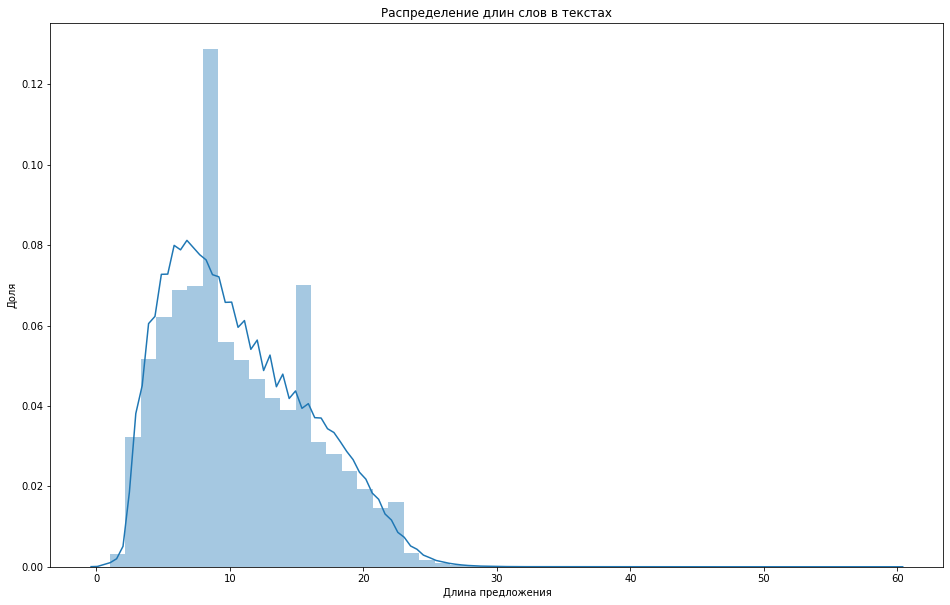

In [20]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [21]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.63 % наших текстов входят в промежуток от 3 до 32 слов'

In [22]:
len(word2freq)

154153

In [23]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'116650 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [0]:
import numpy as np

In [25]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [01:07<00:00, 29669.71it/s]


In [26]:
len(word2index)

117700

In [27]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(50):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 1.67 % слов в датасете
Количество неизвестных слов 36454 из 154153, то есть 23.65 % уникальных слов в словаре
В среднем каждое встречается 1.16 раз

Топ 5 невошедших слов:
дошик с количеством вхождениий - 43
егрн с количеством вхождениий - 41
слайм с количеством вхождениий - 39
внп с количеством вхождениий - 37
девчин с количеством вхождениий - 36
♪♫ с количеством вхождениий - 31
wwwyoutubecom с количеством вхождениий - 25
hatsan с количеством вхождениий - 25
%- с количеством вхождениий - 23
-> с количеством вхождениий - 23
сзв с количеством вхождениий - 19
// с количеством вхождениий - 18
комиссация с количеством вхождениий - 18
vkcom с количеством вхождениий - 18
кдн с количеством вхождениий - 17
boozled с количеством вхождениий - 17
фкз с количеством вхождениий - 16
помогитее с количеством вхождениий - 15
быстроденьги с количеством вхождениий - 15
```` с количеством вхождениий - 15
бсо с количеством вхождениий - 15
алиекспресс с количеством вхождениий - 15
` с количество

# Потеря 2.5 % слов в датасете
Эта ситуация не то, чтобы сильно плохая, в учебных целях нормально, к тому же в среднем они редко встречаются. Вы можете поиграть с предобработкой, но советую не заигрываться. Оценивается другое.

In [0]:
import torch

# Подготовим данные в DataLoader

In [0]:
from torch.utils.data import Dataset, DataLoader

In [30]:
'UNK' in word2index

False

# Замапим категории в индексы

In [0]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}
inv_cat_mapper =  {v: k for k, v in cat_mapper.items()}

In [32]:
inv_cat_mapper.keys()

dict_keys([0, 1, 2, 3, 4])

In [33]:
cat_mapper

{'business': 0, 'food': 4, 'law': 1, 'love': 2, 'relax': 3}

In [34]:
len(cat_mapper)

5

In [0]:
data_cats = data.category.map(cat_mapper)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(DATA_TEXTS, data_cats.tolist(), test_size=0.2)

In [37]:
x_train[:10]

['с чем можно пить белое полусладкое вино',
 'помогите найти название индийского фильма важно',
 'могу ли я получить паспорт в 16 спрашивать',
 'какие у вас традиционные блюда на рождество спрашивать',
 'элементарный выбор напитка',
 'могут ли меня задержать спрашивать',
 'где в чите можно найти хорошего наставника в кулинарии кулинария',
 'подскажите пожалуйста как называется песня или исполнитель  трек довольно таки старый но клубный там чет поется маски',
 'вода с бутылки налитая в кружку и выпитая оттуда приносит отвращение а если выпить с бутылки- очень даже вкусно спрашивать',
 'как вы думаете спрашивать  что будет если']

In [38]:
y_train[:10]


[4, 3, 1, 4, 4, 1, 4, 3, 4, 4]

# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.
    
## Что нужно сделать здесь
1. Дописать индексатор текста
1. Дописать паддинг текста
1. __*Опционально:*__ добавить что-то в предобработку

In [0]:
from itertools import repeat

In [0]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        
        # Место для вашей предобработки        
        # aftertext = text.lower().translate(puncts).strip()        
        # words = wordpunct_tokenize(digisep(aftertext))

        words = wordpunct_tokenize(text)

        return words
    
    @classmethod
    def pad():
      return self.pad_index
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose, position=0)
        
        for text in data_iterator:
            
            words = self.process_text(text)
            
            indexed_words = self.indexing(words)
            
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова        
        ### CODE ###
        return [self.word2index[token] for token in tokenized_text if token in self.word2index]
        
            
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        ### CODE ###        
        delta = self.sequence_length - len(sequence)
        return sequence + list(repeat(self.pad_index, delta)) \
        if delta > 0 else sequence[:self.sequence_length]

    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [41]:
dataset = WordData(x_train, y_train, word2index)
datasettest = WordData(x_test, y_test, word2index)
# dataset = WordData(data.text, data.category, word2index)


Loading data: 100%|██████████| 47556/47556 [00:00<00:00, 108567.31it/s]


In [0]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(datasettest, batch_size=BATCH_SIZE, pin_memory=True)

# Обучить нейронку

In [0]:
import warnings
warnings.filterwarnings('ignore')
# warnings break progress bar

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class CoolNet(nn.Module):
  """
  |￣￣￣￣￣￣￣￣￣￣￣|
    I don't know
    what I am doing,
    but it is my neural
    network
  |＿＿＿＿＿＿＿＿＿＿＿|
  (\__/) ||
  (•ㅅ•) ||
  / 　 づ
  """
 
  def __init__(self, vocab_size, hidden_dim, classes_quantity, emb_weights):
    super().__init__()
    self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(emb_weights))
    self.drop = nn.Dropout2d(0.25)    
    embedding_length  = emb_weights.shape[1]
    self.lstm = nn.LSTM(input_size=embedding_length,\
                        hidden_size=hidden_dim,\
                        bidirectional=True, batch_first=True)
    self.linear = nn.Linear(hidden_dim*2, classes_quantity)    
 
    pass



  def forward(self, x):    
    x = self.embeddings(x)
    x = self.drop(x)    
    x, _ =  self.lstm(x)

    # seq_lengths, indexes = (x > 0).sum(1).sort(descending=True)    
    # q = x[indexes]
    # z = pack_padded_sequence(q, seq_lengths, batch_first=True)
    # x, _ =  self.lstm(z)
    # x = pad_packed_sequence(z, batch_first=True)
    # x = x[:, -1, :]
    ##############
    # CUDA error #
    ##############

    x = x[:, -1, :]
    x = self.drop(x)
    x = self.linear(x)
    return x



model = CoolNet(vocab_size=len(word2index), hidden_dim = HIDDEN_SIZE,\
                classes_quantity = len(cat_mapper),\
                emb_weights = vectors)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# torch.cuda.empty_cache()
print("CUDA RAM usage", torch.cuda.max_memory_allocated(device))
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())
# aka loss function
criterion = torch.nn.CrossEntropyLoss()

CUDA RAM usage 0


Current device cuda
Learning rate: 0.0005


Epoch[1] Iteration[500/2973] Loss: 1.0391
Epoch[1] Iteration[1000/2973] Loss: 0.9825
Epoch[1] Iteration[1500/2973] Loss: 0.8110
Epoch[1] Iteration[2000/2973] Loss: 0.8232
Epoch[1] Iteration[2500/2973] Loss: 0.7043
Compute train metrics...
Training Results - Epoch: 1  Average Loss: 0.6680 | Accuracy: 0.7642 | Precision: 0.7449 | Recall: 0.7461  | F1: 0.7442
Compute validation metrics...
Validation Results - Epoch: 1  Average Loss: 0.6711 | Accuracy: 0.7637 | Precision: 0.7458 | Recall: 0.7480 | F1: 0.7456
Learning rate: 0.001


Epoch[2] Iteration[500/2973] Loss: 0.6979
Epoch[2] Iteration[1000/2973] Loss: 0.7408
Epoch[2] Iteration[1500/2973] Loss: 0.4768
Epoch[2] Iteration[2000/2973] Loss: 0.6863
Epoch[2] Iteration[2500/2973] Loss: 0.4649
Compute train metrics...
Training Results - Epoch: 2  Average Loss: 0.5163 | Accuracy: 0.8190 | Precision: 0.8147 | Recall: 0.8156  | F1: 0.8145
Compute validation metrics...
Validation Results - Epoch: 2  Average Loss: 0.5217 | Accuracy: 0.8157 | Precision: 0.8112 | Recall: 0.8136 | F1: 0.8117
Learning rate: 0.0005


Epoch[3] Iteration[500/2973] Loss: 0.6225
Epoch[3] Iteration[1000/2973] Loss: 0.5737
Epoch[3] Iteration[1500/2973] Loss: 0.4324
Epoch[3] Iteration[2000/2973] Loss: 0.6863
Epoch[3] Iteration[2500/2973] Loss: 0.6124
Compute train metrics...
Training Results - Epoch: 3  Average Loss: 0.4885 | Accuracy: 0.8257 | Precision: 0.8225 | Recall: 0.8242  | F1: 0.8232
Compute validation metrics...
Validation Results - Epoch: 3  Average Loss: 0.4952 | Accuracy: 0.8228 | Precision: 0.8196 | Recall: 0.8216 | F1: 0.8205
Learning rate: 0.001


Epoch[4] Iteration[500/2973] Loss: 0.5543
Epoch[4] Iteration[1000/2973] Loss: 0.5202
Epoch[4] Iteration[1500/2973] Loss: 0.4314
Epoch[4] Iteration[2000/2973] Loss: 0.6264
Epoch[4] Iteration[2500/2973] Loss: 0.5022
Compute train metrics...
Training Results - Epoch: 4  Average Loss: 0.4865 | Accuracy: 0.8263 | Precision: 0.8190 | Recall: 0.8296  | F1: 0.8236
Compute validation metrics...
Validation Results - Epoch: 4  Average Loss: 0.4950 | Accuracy: 0.8215 | Precision: 0.8141 | Recall: 0.8248 | F1: 0.8187
Learning rate: 0.0005


Epoch[5] Iteration[500/2973] Loss: 0.5685
Epoch[5] Iteration[1000/2973] Loss: 0.5803
Epoch[5] Iteration[1500/2973] Loss: 0.4023
Epoch[5] Iteration[2000/2973] Loss: 0.7074
Epoch[5] Iteration[2500/2973] Loss: 0.3872
Compute train metrics...
Training Results - Epoch: 5  Average Loss: 0.4651 | Accuracy: 0.8307 | Precision: 0.8271 | Recall: 0.8325  | F1: 0.8294
Compute validation metrics...
Validation Results - Epoch: 5  Average Loss: 0.4753 | Accuracy: 0.8257 | Precision: 0.8222 | Recall: 0.8276 | F1: 0.8244
Learning rate: 0.001


Epoch[6] Iteration[500/2973] Loss: 0.5299
Epoch[6] Iteration[1000/2973] Loss: 0.6383
Epoch[6] Iteration[1500/2973] Loss: 0.4151
Epoch[6] Iteration[2000/2973] Loss: 0.7179
Epoch[6] Iteration[2500/2973] Loss: 0.4174
Compute train metrics...
Training Results - Epoch: 6  Average Loss: 0.4562 | Accuracy: 0.8354 | Precision: 0.8359 | Recall: 0.8311  | F1: 0.8332
Compute validation metrics...
Validation Results - Epoch: 6  Average Loss: 0.4682 | Accuracy: 0.8309 | Precision: 0.8316 | Recall: 0.8267 | F1: 0.8289
Learning rate: 0.0005


Epoch[7] Iteration[500/2973] Loss: 0.5552
Epoch[7] Iteration[1000/2973] Loss: 0.5395
Epoch[7] Iteration[1500/2973] Loss: 0.4066
Epoch[7] Iteration[2000/2973] Loss: 0.6472
Epoch[7] Iteration[2500/2973] Loss: 0.4454
Compute train metrics...
Training Results - Epoch: 7  Average Loss: 0.4448 | Accuracy: 0.8373 | Precision: 0.8328 | Recall: 0.8390  | F1: 0.8355
Compute validation metrics...
Validation Results - Epoch: 7  Average Loss: 0.4591 | Accuracy: 0.8329 | Precision: 0.8283 | Recall: 0.8349 | F1: 0.8312
Learning rate: 0.001


Epoch[8] Iteration[500/2973] Loss: 0.5622
Epoch[8] Iteration[1000/2973] Loss: 0.6518
Epoch[8] Iteration[1500/2973] Loss: 0.3835
Epoch[8] Iteration[2000/2973] Loss: 0.6319
Epoch[8] Iteration[2500/2973] Loss: 0.4294
Compute train metrics...
Training Results - Epoch: 8  Average Loss: 0.4476 | Accuracy: 0.8380 | Precision: 0.8358 | Recall: 0.8396  | F1: 0.8373
Compute validation metrics...
Validation Results - Epoch: 8  Average Loss: 0.4644 | Accuracy: 0.8308 | Precision: 0.8284 | Recall: 0.8325 | F1: 0.8300
Learning rate: 0.0005


Epoch[9] Iteration[500/2973] Loss: 0.5559
Epoch[9] Iteration[1000/2973] Loss: 0.4648
Epoch[9] Iteration[1500/2973] Loss: 0.3992
Epoch[9] Iteration[2000/2973] Loss: 0.6380
Epoch[9] Iteration[2500/2973] Loss: 0.3718
Compute train metrics...
Training Results - Epoch: 9  Average Loss: 0.4305 | Accuracy: 0.8416 | Precision: 0.8392 | Recall: 0.8420  | F1: 0.8402
Compute validation metrics...
Validation Results - Epoch: 9  Average Loss: 0.4475 | Accuracy: 0.8362 | Precision: 0.8337 | Recall: 0.8366 | F1: 0.8348
Learning rate: 0.001


Epoch[10] Iteration[500/2973] Loss: 0.4483
Epoch[10] Iteration[1000/2973] Loss: 0.5690
Epoch[10] Iteration[1500/2973] Loss: 0.3741
Epoch[10] Iteration[2000/2973] Loss: 0.6969
Epoch[10] Iteration[2500/2973] Loss: 0.4370
Compute train metrics...
Training Results - Epoch: 10  Average Loss: 0.4304 | Accuracy: 0.8431 | Precision: 0.8415 | Recall: 0.8411  | F1: 0.8411
Compute validation metrics...
Validation Results - Epoch: 10  Average Loss: 0.4494 | Accuracy: 0.8359 | Precision: 0.8339 | Recall: 0.8342 | F1: 0.8339
Learning rate: 0.0005


Epoch[11] Iteration[500/2973] Loss: 0.5285
Epoch[11] Iteration[1000/2973] Loss: 0.5859
Epoch[11] Iteration[1500/2973] Loss: 0.5018
Epoch[11] Iteration[2000/2973] Loss: 0.6404
Epoch[11] Iteration[2500/2973] Loss: 0.3594
Compute train metrics...
Training Results - Epoch: 11  Average Loss: 0.4166 | Accuracy: 0.8481 | Precision: 0.8467 | Recall: 0.8456  | F1: 0.8461
Compute validation metrics...
Validation Results - Epoch: 11  Average Loss: 0.4390 | Accuracy: 0.8413 | Precision: 0.8393 | Recall: 0.8395 | F1: 0.8394
Learning rate: 0.001


Epoch[12] Iteration[500/2973] Loss: 0.5156
Epoch[12] Iteration[1000/2973] Loss: 0.5596
Epoch[12] Iteration[1500/2973] Loss: 0.3497
Epoch[12] Iteration[2000/2973] Loss: 0.6143
Epoch[12] Iteration[2500/2973] Loss: 0.3352
Compute train metrics...
Training Results - Epoch: 12  Average Loss: 0.4190 | Accuracy: 0.8468 | Precision: 0.8469 | Recall: 0.8431  | F1: 0.8447
Compute validation metrics...
Validation Results - Epoch: 12  Average Loss: 0.4435 | Accuracy: 0.8391 | Precision: 0.8390 | Recall: 0.8358 | F1: 0.8371
Learning rate: 0.0005


Epoch[13] Iteration[500/2973] Loss: 0.5891
Epoch[13] Iteration[1000/2973] Loss: 0.4964
Epoch[13] Iteration[1500/2973] Loss: 0.3884
Epoch[13] Iteration[2000/2973] Loss: 0.6119
Epoch[13] Iteration[2500/2973] Loss: 0.3599
Compute train metrics...
Training Results - Epoch: 13  Average Loss: 0.4085 | Accuracy: 0.8512 | Precision: 0.8456 | Recall: 0.8530  | F1: 0.8491
Compute validation metrics...
Validation Results - Epoch: 13  Average Loss: 0.4368 | Accuracy: 0.8413 | Precision: 0.8356 | Recall: 0.8440 | F1: 0.8395
Learning rate: 0.001


Epoch[14] Iteration[500/2973] Loss: 0.5818
Epoch[14] Iteration[1000/2973] Loss: 0.5153
Epoch[14] Iteration[1500/2973] Loss: 0.3431
Epoch[14] Iteration[2000/2973] Loss: 0.6300
Epoch[14] Iteration[2500/2973] Loss: 0.4059
Compute train metrics...
Training Results - Epoch: 14  Average Loss: 0.4090 | Accuracy: 0.8511 | Precision: 0.8485 | Recall: 0.8504  | F1: 0.8494
Compute validation metrics...
Validation Results - Epoch: 14  Average Loss: 0.4382 | Accuracy: 0.8430 | Precision: 0.8406 | Recall: 0.8431 | F1: 0.8418
Learning rate: 0.0005


Epoch[15] Iteration[500/2973] Loss: 0.5799
Epoch[15] Iteration[1000/2973] Loss: 0.5690
Epoch[15] Iteration[1500/2973] Loss: 0.4157
Epoch[15] Iteration[2000/2973] Loss: 0.5769
Epoch[15] Iteration[2500/2973] Loss: 0.3422
Compute train metrics...
Training Results - Epoch: 15  Average Loss: 0.4013 | Accuracy: 0.8538 | Precision: 0.8517 | Recall: 0.8530  | F1: 0.8522
Compute validation metrics...
Validation Results - Epoch: 15  Average Loss: 0.4337 | Accuracy: 0.8434 | Precision: 0.8410 | Recall: 0.8433 | F1: 0.8420
Learning rate: 0.001


Epoch[16] Iteration[500/2973] Loss: 0.6132
Epoch[16] Iteration[1000/2973] Loss: 0.4976
Epoch[16] Iteration[1500/2973] Loss: 0.3772
Epoch[16] Iteration[2000/2973] Loss: 0.5443
Epoch[16] Iteration[2500/2973] Loss: 0.4515
Compute train metrics...
Training Results - Epoch: 16  Average Loss: 0.4072 | Accuracy: 0.8526 | Precision: 0.8494 | Recall: 0.8515  | F1: 0.8503
Compute validation metrics...
Validation Results - Epoch: 16  Average Loss: 0.4398 | Accuracy: 0.8425 | Precision: 0.8390 | Recall: 0.8423 | F1: 0.8405
Learning rate: 0.0005


Epoch[17] Iteration[500/2973] Loss: 0.5928
Epoch[17] Iteration[1000/2973] Loss: 0.5082
Epoch[17] Iteration[1500/2973] Loss: 0.3843
Epoch[17] Iteration[2000/2973] Loss: 0.5086
Epoch[17] Iteration[2500/2973] Loss: 0.3640
Compute train metrics...
Training Results - Epoch: 17  Average Loss: 0.3945 | Accuracy: 0.8559 | Precision: 0.8530 | Recall: 0.8557  | F1: 0.8542
Compute validation metrics...
Validation Results - Epoch: 17  Average Loss: 0.4317 | Accuracy: 0.8430 | Precision: 0.8400 | Recall: 0.8435 | F1: 0.8416
Learning rate: 0.001


Epoch[18] Iteration[500/2973] Loss: 0.4783
Epoch[18] Iteration[1000/2973] Loss: 0.5222
Epoch[18] Iteration[1500/2973] Loss: 0.3637
Epoch[18] Iteration[2000/2973] Loss: 0.6239
Epoch[18] Iteration[2500/2973] Loss: 0.3484
Compute train metrics...
Training Results - Epoch: 18  Average Loss: 0.3990 | Accuracy: 0.8541 | Precision: 0.8495 | Recall: 0.8563  | F1: 0.8525
Compute validation metrics...
Validation Results - Epoch: 18  Average Loss: 0.4362 | Accuracy: 0.8428 | Precision: 0.8384 | Recall: 0.8455 | F1: 0.8414
Learning rate: 0.0005


Epoch[19] Iteration[500/2973] Loss: 0.5101
Epoch[19] Iteration[1000/2973] Loss: 0.5468
Epoch[19] Iteration[1500/2973] Loss: 0.3023
Epoch[19] Iteration[2000/2973] Loss: 0.6822
Epoch[19] Iteration[2500/2973] Loss: 0.4026
Compute train metrics...
Training Results - Epoch: 19  Average Loss: 0.3852 | Accuracy: 0.8594 | Precision: 0.8555 | Recall: 0.8592  | F1: 0.8573
Compute validation metrics...
Validation Results - Epoch: 19  Average Loss: 0.4279 | Accuracy: 0.8460 | Precision: 0.8421 | Recall: 0.8466 | F1: 0.8442
Learning rate: 0.001


Epoch[20] Iteration[500/2973] Loss: 0.5247
Epoch[20] Iteration[1000/2973] Loss: 0.4545
Epoch[20] Iteration[1500/2973] Loss: 0.3795
Epoch[20] Iteration[2000/2973] Loss: 0.6523
Epoch[20] Iteration[2500/2973] Loss: 0.3408
Compute train metrics...
Training Results - Epoch: 20  Average Loss: 0.3860 | Accuracy: 0.8584 | Precision: 0.8535 | Recall: 0.8588  | F1: 0.8559
Compute validation metrics...
Validation Results - Epoch: 20  Average Loss: 0.4285 | Accuracy: 0.8461 | Precision: 0.8411 | Recall: 0.8471 | F1: 0.8438
Learning rate: 0.0005


Epoch[21] Iteration[500/2973] Loss: 0.4941
Epoch[21] Iteration[1000/2973] Loss: 0.5694
Epoch[21] Iteration[1500/2973] Loss: 0.3391
Epoch[21] Iteration[2000/2973] Loss: 0.4603
Epoch[21] Iteration[2500/2973] Loss: 0.4412
Compute train metrics...
Training Results - Epoch: 21  Average Loss: 0.3802 | Accuracy: 0.8615 | Precision: 0.8579 | Recall: 0.8607  | F1: 0.8593
Compute validation metrics...
Validation Results - Epoch: 21  Average Loss: 0.4273 | Accuracy: 0.8467 | Precision: 0.8430 | Recall: 0.8467 | F1: 0.8447
Learning rate: 0.001


Epoch[22] Iteration[500/2973] Loss: 0.5760
Epoch[22] Iteration[1000/2973] Loss: 0.5629
Epoch[22] Iteration[1500/2973] Loss: 0.3383
Epoch[22] Iteration[2000/2973] Loss: 0.5342
Epoch[22] Iteration[2500/2973] Loss: 0.4271
Compute train metrics...
Training Results - Epoch: 22  Average Loss: 0.3870 | Accuracy: 0.8588 | Precision: 0.8583 | Recall: 0.8572  | F1: 0.8574
Compute validation metrics...
Validation Results - Epoch: 22  Average Loss: 0.4365 | Accuracy: 0.8443 | Precision: 0.8433 | Recall: 0.8433 | F1: 0.8430
Learning rate: 0.0005


Epoch[23] Iteration[500/2973] Loss: 0.5658
Epoch[23] Iteration[1000/2973] Loss: 0.6031
Epoch[23] Iteration[1500/2973] Loss: 0.3919
Epoch[23] Iteration[2000/2973] Loss: 0.5866
Epoch[23] Iteration[2500/2973] Loss: 0.3581
Compute train metrics...
Training Results - Epoch: 23  Average Loss: 0.3729 | Accuracy: 0.8647 | Precision: 0.8602 | Recall: 0.8637  | F1: 0.8617
Compute validation metrics...
Validation Results - Epoch: 23  Average Loss: 0.4252 | Accuracy: 0.8470 | Precision: 0.8425 | Recall: 0.8470 | F1: 0.8444
Learning rate: 0.001


Epoch[24] Iteration[500/2973] Loss: 0.5456
Epoch[24] Iteration[1000/2973] Loss: 0.5587
Epoch[24] Iteration[1500/2973] Loss: 0.3468
Epoch[24] Iteration[2000/2973] Loss: 0.6564
Epoch[24] Iteration[2500/2973] Loss: 0.4031
Compute train metrics...
Training Results - Epoch: 24  Average Loss: 0.3787 | Accuracy: 0.8617 | Precision: 0.8556 | Recall: 0.8634  | F1: 0.8592
Compute validation metrics...
Validation Results - Epoch: 24  Average Loss: 0.4313 | Accuracy: 0.8451 | Precision: 0.8387 | Recall: 0.8475 | F1: 0.8427
Learning rate: 0.0005


Epoch[25] Iteration[500/2973] Loss: 0.5587
Epoch[25] Iteration[1000/2973] Loss: 0.4509
Epoch[25] Iteration[1500/2973] Loss: 0.3496
Epoch[25] Iteration[2000/2973] Loss: 0.5357
Epoch[25] Iteration[2500/2973] Loss: 0.3808
Compute train metrics...
Training Results - Epoch: 25  Average Loss: 0.3665 | Accuracy: 0.8665 | Precision: 0.8646 | Recall: 0.8633  | F1: 0.8639
Compute validation metrics...
Validation Results - Epoch: 25  Average Loss: 0.4242 | Accuracy: 0.8485 | Precision: 0.8465 | Recall: 0.8459 | F1: 0.8462
Learning rate: 0.001


Epoch[26] Iteration[500/2973] Loss: 0.4415
Epoch[26] Iteration[1000/2973] Loss: 0.5074
Epoch[26] Iteration[1500/2973] Loss: 0.3336
Epoch[26] Iteration[2000/2973] Loss: 0.4940
Epoch[26] Iteration[2500/2973] Loss: 0.3615
Compute train metrics...
Training Results - Epoch: 26  Average Loss: 0.3783 | Accuracy: 0.8642 | Precision: 0.8617 | Recall: 0.8634  | F1: 0.8625
Compute validation metrics...
Validation Results - Epoch: 26  Average Loss: 0.4328 | Accuracy: 0.8463 | Precision: 0.8436 | Recall: 0.8463 | F1: 0.8448
Learning rate: 0.0005


Epoch[27] Iteration[500/2973] Loss: 0.5356
Epoch[27] Iteration[1000/2973] Loss: 0.5647
Epoch[27] Iteration[1500/2973] Loss: 0.4564
Epoch[27] Iteration[2000/2973] Loss: 0.6670
Epoch[27] Iteration[2500/2973] Loss: 0.4513
Compute train metrics...
Training Results - Epoch: 27  Average Loss: 0.3652 | Accuracy: 0.8675 | Precision: 0.8643 | Recall: 0.8670  | F1: 0.8656
Compute validation metrics...
Validation Results - Epoch: 27  Average Loss: 0.4247 | Accuracy: 0.8471 | Precision: 0.8435 | Recall: 0.8477 | F1: 0.8455
Learning rate: 0.001


Epoch[28] Iteration[500/2973] Loss: 0.4486
Epoch[28] Iteration[1000/2973] Loss: 0.5943
Epoch[28] Iteration[1500/2973] Loss: 0.3447
Epoch[28] Iteration[2000/2973] Loss: 0.6529
Epoch[28] Iteration[2500/2973] Loss: 0.3478
Compute train metrics...
Training Results - Epoch: 28  Average Loss: 0.3717 | Accuracy: 0.8638 | Precision: 0.8626 | Recall: 0.8637  | F1: 0.8629
Compute validation metrics...
Validation Results - Epoch: 28  Average Loss: 0.4315 | Accuracy: 0.8442 | Precision: 0.8428 | Recall: 0.8448 | F1: 0.8435
Learning rate: 0.0005


Epoch[29] Iteration[500/2973] Loss: 0.4767
Epoch[29] Iteration[1000/2973] Loss: 0.5229
Epoch[29] Iteration[1500/2973] Loss: 0.3449
Epoch[29] Iteration[2000/2973] Loss: 0.5596
Epoch[29] Iteration[2500/2973] Loss: 0.3921
Compute train metrics...
Training Results - Epoch: 29  Average Loss: 0.3600 | Accuracy: 0.8692 | Precision: 0.8700 | Recall: 0.8642  | F1: 0.8668
Compute validation metrics...
Validation Results - Epoch: 29  Average Loss: 0.4245 | Accuracy: 0.8479 | Precision: 0.8483 | Recall: 0.8438 | F1: 0.8458
Learning rate: 0.001


Epoch[30] Iteration[500/2973] Loss: 0.5445
Epoch[30] Iteration[1000/2973] Loss: 0.5208
Epoch[30] Iteration[1500/2973] Loss: 0.3726
Epoch[30] Iteration[2000/2973] Loss: 0.5966
Epoch[30] Iteration[2500/2973] Loss: 0.5012
Compute train metrics...
Training Results - Epoch: 30  Average Loss: 0.3622 | Accuracy: 0.8678 | Precision: 0.8664 | Recall: 0.8663  | F1: 0.8663
Compute validation metrics...
Validation Results - Epoch: 30  Average Loss: 0.4293 | Accuracy: 0.8469 | Precision: 0.8450 | Recall: 0.8457 | F1: 0.8453
Learning rate: 0.0005


Epoch[31] Iteration[500/2973] Loss: 0.4883
Epoch[31] Iteration[1000/2973] Loss: 0.4222
Epoch[31] Iteration[1500/2973] Loss: 0.3612
Epoch[31] Iteration[2000/2973] Loss: 0.4889
Epoch[31] Iteration[2500/2973] Loss: 0.3323
Compute train metrics...
Training Results - Epoch: 31  Average Loss: 0.3534 | Accuracy: 0.8706 | Precision: 0.8683 | Recall: 0.8704  | F1: 0.8692
Compute validation metrics...
Validation Results - Epoch: 31  Average Loss: 0.4227 | Accuracy: 0.8495 | Precision: 0.8469 | Recall: 0.8498 | F1: 0.8482
Learning rate: 0.001


Epoch[32] Iteration[500/2973] Loss: 0.5628
Epoch[32] Iteration[1000/2973] Loss: 0.5307
Epoch[32] Iteration[1500/2973] Loss: 0.3234
Epoch[32] Iteration[2000/2973] Loss: 0.6756
Epoch[32] Iteration[2500/2973] Loss: 0.3242
Compute train metrics...
Training Results - Epoch: 32  Average Loss: 0.3549 | Accuracy: 0.8705 | Precision: 0.8695 | Recall: 0.8676  | F1: 0.8685
Compute validation metrics...
Validation Results - Epoch: 32  Average Loss: 0.4270 | Accuracy: 0.8491 | Precision: 0.8476 | Recall: 0.8467 | F1: 0.8472
Learning rate: 0.0005


Epoch[33] Iteration[500/2973] Loss: 0.4992
Epoch[33] Iteration[1000/2973] Loss: 0.5236
Epoch[33] Iteration[1500/2973] Loss: 0.3281
Epoch[33] Iteration[2000/2973] Loss: 0.6747
Epoch[33] Iteration[2500/2973] Loss: 0.3645
Compute train metrics...
Training Results - Epoch: 33  Average Loss: 0.3511 | Accuracy: 0.8725 | Precision: 0.8698 | Recall: 0.8709  | F1: 0.8703
Compute validation metrics...
Validation Results - Epoch: 33  Average Loss: 0.4275 | Accuracy: 0.8499 | Precision: 0.8469 | Recall: 0.8491 | F1: 0.8480
Learning rate: 0.001


Epoch[34] Iteration[500/2973] Loss: 0.4190
Epoch[34] Iteration[1000/2973] Loss: 0.5036
Epoch[34] Iteration[1500/2973] Loss: 0.2483
Epoch[34] Iteration[2000/2973] Loss: 0.6533
Epoch[34] Iteration[2500/2973] Loss: 0.3615
Compute train metrics...
Training Results - Epoch: 34  Average Loss: 0.3545 | Accuracy: 0.8711 | Precision: 0.8696 | Recall: 0.8677  | F1: 0.8685
Compute validation metrics...
Validation Results - Epoch: 34  Average Loss: 0.4306 | Accuracy: 0.8493 | Precision: 0.8474 | Recall: 0.8467 | F1: 0.8469
Learning rate: 0.0005


Epoch[35] Iteration[500/2973] Loss: 0.4697
Epoch[35] Iteration[1000/2973] Loss: 0.5499
Epoch[35] Iteration[1500/2973] Loss: 0.4150
Epoch[35] Iteration[2000/2973] Loss: 0.7046
Epoch[35] Iteration[2500/2973] Loss: 0.3273
Compute train metrics...
Training Results - Epoch: 35  Average Loss: 0.3430 | Accuracy: 0.8751 | Precision: 0.8721 | Recall: 0.8736  | F1: 0.8728
Compute validation metrics...
Validation Results - Epoch: 35  Average Loss: 0.4238 | Accuracy: 0.8508 | Precision: 0.8473 | Recall: 0.8500 | F1: 0.8486
Learning rate: 0.001


Epoch[36] Iteration[500/2973] Loss: 0.5638
Epoch[36] Iteration[1000/2973] Loss: 0.5194
Epoch[36] Iteration[1500/2973] Loss: 0.3766
Epoch[36] Iteration[2000/2973] Loss: 0.5553
Epoch[36] Iteration[2500/2973] Loss: 0.3676
Compute train metrics...
Training Results - Epoch: 36  Average Loss: 0.3492 | Accuracy: 0.8730 | Precision: 0.8722 | Recall: 0.8707  | F1: 0.8714
Compute validation metrics...
Validation Results - Epoch: 36  Average Loss: 0.4273 | Accuracy: 0.8493 | Precision: 0.8483 | Recall: 0.8477 | F1: 0.8479
Learning rate: 0.0005


Epoch[37] Iteration[500/2973] Loss: 0.5942
Epoch[37] Iteration[1000/2973] Loss: 0.4756
Epoch[37] Iteration[1500/2973] Loss: 0.3156
Epoch[37] Iteration[2000/2973] Loss: 0.5944
Epoch[37] Iteration[2500/2973] Loss: 0.3873
Compute train metrics...
Training Results - Epoch: 37  Average Loss: 0.3414 | Accuracy: 0.8760 | Precision: 0.8758 | Recall: 0.8719  | F1: 0.8738
Compute validation metrics...
Validation Results - Epoch: 37  Average Loss: 0.4257 | Accuracy: 0.8499 | Precision: 0.8489 | Recall: 0.8468 | F1: 0.8478
Learning rate: 0.001


Epoch[38] Iteration[500/2973] Loss: 0.4589
Epoch[38] Iteration[1000/2973] Loss: 0.5015
Epoch[38] Iteration[1500/2973] Loss: 0.3208
Epoch[38] Iteration[2000/2973] Loss: 0.5433
Epoch[38] Iteration[2500/2973] Loss: 0.3868
Compute train metrics...
Training Results - Epoch: 38  Average Loss: 0.3455 | Accuracy: 0.8744 | Precision: 0.8708 | Recall: 0.8747  | F1: 0.8727
Compute validation metrics...
Validation Results - Epoch: 38  Average Loss: 0.4248 | Accuracy: 0.8489 | Precision: 0.8446 | Recall: 0.8496 | F1: 0.8470
Learning rate: 0.0005


Epoch[39] Iteration[500/2973] Loss: 0.6259
Epoch[39] Iteration[1000/2973] Loss: 0.4564
Epoch[39] Iteration[1500/2973] Loss: 0.3173
Epoch[39] Iteration[2000/2973] Loss: 0.4664
Epoch[39] Iteration[2500/2973] Loss: 0.3535
Compute train metrics...
Training Results - Epoch: 39  Average Loss: 0.3355 | Accuracy: 0.8776 | Precision: 0.8758 | Recall: 0.8750  | F1: 0.8753
Compute validation metrics...
Validation Results - Epoch: 39  Average Loss: 0.4238 | Accuracy: 0.8493 | Precision: 0.8468 | Recall: 0.8472 | F1: 0.8469
Learning rate: 0.001


Epoch[40] Iteration[500/2973] Loss: 0.5388
Epoch[40] Iteration[1000/2973] Loss: 0.4892
Epoch[40] Iteration[1500/2973] Loss: 0.3128
Epoch[40] Iteration[2000/2973] Loss: 0.4752
Epoch[40] Iteration[2500/2973] Loss: 0.3699
Compute train metrics...
Training Results - Epoch: 40  Average Loss: 0.3421 | Accuracy: 0.8746 | Precision: 0.8729 | Recall: 0.8735  | F1: 0.8731
Compute validation metrics...
Validation Results - Epoch: 40  Average Loss: 0.4286 | Accuracy: 0.8484 | Precision: 0.8464 | Recall: 0.8473 | F1: 0.8466
Compute final results...
Final F1 0.8466
Learning process is completed.


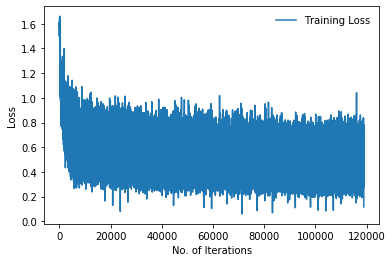

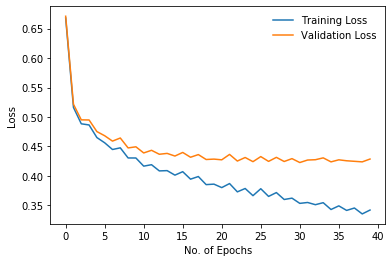

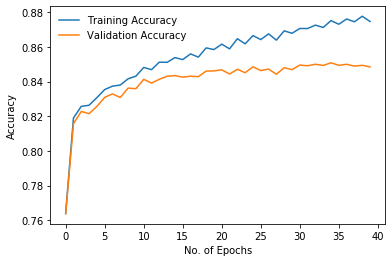

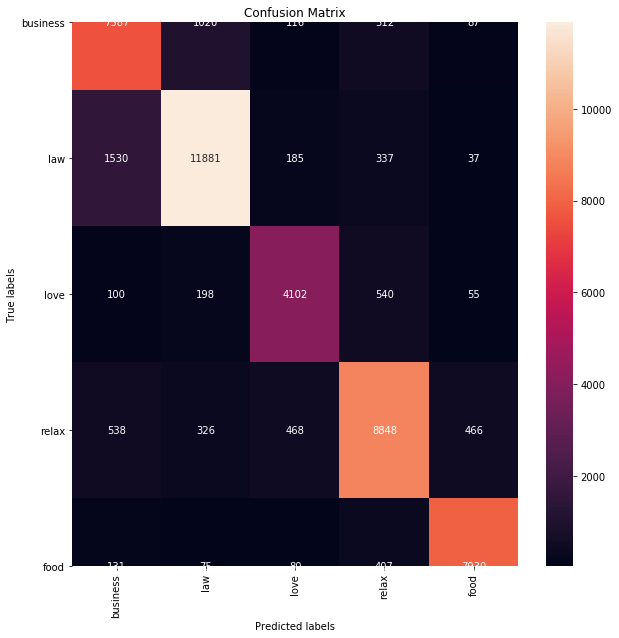

In [45]:
from ignite.engine import Engine, _prepare_batch, Events, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy, Precision, Recall, Loss, ConfusionMatrix, IoU
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import EarlyStopping
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts



# lr_scheduler = ExponentialLR(optimizer, gamma=0.8)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = 2)

def f1(precision, recall):
  return (precision * recall * 2.0 / (precision + recall)).mean()

log_interval = LOG_ITERATIONS
epochs = EPOCHS_NUM

metrics = {
    'avg_loss': Loss(criterion),
    'avg_accuracy': Accuracy(),
    'avg_precision': Precision(average=True),
    'avg_recall': Recall(average=True),
    'prec': Precision(average=False),
    'rec': Recall(average=False),
    'nll': Loss(criterion),
    'cm': ConfusionMatrix(num_classes=len(cat_mapper))
}

def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def create_supervised_evaluator(model, metrics={}, device=None):
    if device:
        model.to(device)

    def _inference(engine, batch):
        model.eval()
        with torch.no_grad():
            x, y = _prepare_batch(batch, device=device)
            y_pred = model(x)
            return y_pred, y

    engine = Engine(_inference)

    for name, metric in metrics.items():
        metric.attach(engine, name)

    return engine    
################################################################################
print("Current device", device)

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

# trainer = Engine(process_function)

from ignite.engine import create_supervised_trainer

trainer = create_supervised_trainer(model, optimizer, criterion, device)

training_history = {'accuracy':[],'loss':[], 'f1':[]}
validation_history = {'accuracy':[],'loss':[], 'f1':[]}
loss_history = []

def score_function(engine):
    # loss growth monitoring
    # val_loss = engine.state.metrics['nll']
    # return -val_loss
    # f1
    return f1(engine.state.metrics['prec'], engine.state.metrics['rec'])

early_stopping = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

pbar = ProgressBar()
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

# cm = ConfusionMatrix(num_classes=5)
# IoU(cm, ignore_index=0).attach(train_evaluator, 'IoU')

@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
        print("Learning rate: {}".format(lr))
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])
            print("Learning rate (group {}): {}".format(i, lr))


@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(train_loader) + 1
    loss_history.append(engine.state.output)
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"
              .format(engine.state.epoch, 
                         iteration, 
                         len(train_loader), 
                         engine.state.output))


@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_loader).metrics
    f1val = f1(metrics['prec'], metrics['rec'])
    accuracy = metrics['avg_accuracy']
    training_history['accuracy'].append(accuracy)
    avgloss  = metrics['avg_loss']
    training_history['loss'].append(avgloss)
    training_history['f1'].append(f1)

  
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}  | F1: {:.4f}"
          .format(engine.state.epoch, 
                      avgloss, 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                      f1val
                  ))

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(test_loader).metrics
    f1val = f1(metrics['prec'], metrics['rec'])
    accuracy = metrics['avg_accuracy']
    validation_history['accuracy'].append(accuracy)    
    avgloss  = metrics['avg_loss']
    validation_history['loss'].append(avgloss)
    validation_history['f1'].append(f1)    
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_loss'], 
                      accuracy, 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                     f1val
                  ))

@trainer.on(Events.COMPLETED)
def display_farewell(engine):
  print("Compute final results...")  
  metrics = val_evaluator.run(test_loader).metrics   
  print("Final F1 {0:.4f}".format(f1(metrics['prec'], metrics['rec'])))
  print("Learning process is completed.")
  
  # metrics = train_evaluator.run(test_loader).metrics   
  # print(metrics['IoU'])

@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    # print(loss_history)

    plt.plot(loss_history,label="Training Loss")    
    plt.xlabel('No. of Iterations')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    # plt.set_ylim(ymin=0)
    plt.show()

    plt.plot(training_history['loss'],label="Training Loss")
    plt.plot(validation_history['loss'],label="Validation Loss")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    # plt.set_ylim(ymin=0)
    plt.show()

  

    plt.plot(training_history['accuracy'],label="Training Accuracy")
    plt.plot(validation_history['accuracy'],label="Validation Accuracy")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)
    plt.show()

    val_evaluator.run(test_loader)
    metrics_state = val_evaluator.state.metrics
    cm = metrics_state['cm']

    cm = cm.numpy()
    cm = cm.astype(int)    
    classes = list(inv_cat_mapper.values())    
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)  

try:
  output = trainer.run(train_loader, max_epochs=epochs)
except KeyboardInterrupt:
  print("Interrupted, exit.")




**Эксперименты**

Пробовал менять размер скрытого слоя, 64 показался наилучшим вариантом, меньше - хуже, а больше - к тому же и медленнее обрабатываются данные. Очень хороший прирост дал перенос на GPU.

Прикручивание нелинейности на выходе ничего не дало. Не замерял, но субъективно очень пригодился дропаут.
Непонятно с EarlyDropping, пробовал делать с разными параметрами, вроде падения лосса на паре эпох.
Но с данным датасетом такая штука, что если ставить какие-то очевидные критерии для дропинга, вроде переобучения (падения F-меры на валидации при росте на трейне), то остановка происходит где-то после 10-й эпохи. Однако практика показала, что елси ставить более 15 эпох, то сеть бьёт 0.84.
После создания текущей архитектуры сеть никак не хотела обучиться лучше 0.83. Чтобы что-то сделать я решил уменьшить энтропию данных, поэтому сделал обработку смайликов и убрал non-alphanumeric characters.


Очень доволен Ignite'ом, гораздо проще кастомизация обучения. Правда, документация местами бедновата.

Что-то странное с длинами при упаковке тензора для LSTM, похоже именно с ними связана ошибка
*RuntimeError: CUDA error: device-side assert triggered*. К сожалению, эта информация об ошибке не особо полезна, мне так и не удалось найти причину.

К тому же, после первого проявления эта ошибка начинает возникать на этапе загрузки модели, для чего нужно заново перезапускать среду выполнения, а это требует много времени.